## X-Ray Abnormality Detection with VGG19

> **Giogiakas Sotirios** ( *p3352204* ) <br />
> **Sakkis Panagiotis** ( *p3352222* ) <br />
> **MSc in Data Science, AUEB**

In [1]:
import os
import pathlib
import random
import re
from glob import glob

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf
import tensorflow_addons as tfa
from sklearn.metrics import cohen_kappa_score
from sklearn.utils import shuffle

#import keras_tuner as kt
from tensorflow.keras.callbacks import EarlyStopping
from enum import Enum
#import cv2
from tensorflow.keras import backend as K # Importing Keras backend (by default it is Tensorflow)
import gc
from tensorflow.keras.utils import to_categorical
from keras_preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from tensorflow.keras.optimizers import SGD, Adam
#from keras_adabound import AdaBound
from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.keras.layers import Input, Conv2D,BatchNormalization
from tensorflow.keras.layers import Activation,SpatialDropout2D,AvgPool2D
from tensorflow.keras.layers import MaxPool2D,Dropout,GlobalAveragePooling2D
from tensorflow.keras.layers import GlobalMaxPooling2D,Flatten,Dropout,Dense
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras import Sequential
from tensorflow_addons.metrics import CohenKappa
from tensorflow.keras.metrics import AUC, BinaryAccuracy
from sklearn.metrics import cohen_kappa_score, accuracy_score
from tensorflow.keras.applications import ResNet152V2
from tensorflow.keras.applications import DenseNet121,DenseNet169,DenseNet201
from tensorflow.keras.models import load_model
from numpy import dstack
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import VotingClassifier
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.applications.vgg19 import VGG19
from tensorflow.keras.applications.resnet50 import ResNet50


pd.set_option("max_colwidth", None)
plt.style.use("dark_background")

c:\Users\sotir\anaconda3\envs\myenv4\lib\site-packages\tensorflow_addons\utils\tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(
c:\Users\sotir\anaconda3\envs\myenv4\lib\site-packages\tensorflow_addons\utils\ensure_tf_install.py:53: UserWarning: Tensorflow Addons supports using Python ops for all Tensorflow versions above or equal to 2.12.0 and strictly below 2.15.0 (nightly versions are not supported). 
 The versions of TensorFlow you are currently using is 2.10.0 and is not supported. 
Some things might work, some things might not.
If you were to encounter a bug, do not file an issue.
If 

In [2]:
def inspect_df(df: pd.DataFrame, n: int = 5) -> pd.DataFrame:
    """Helper method to easily inspect DataFrames."""

    print(f"shape: {df.shape}")

    return df.head(n)


def clean_up(model_):
    """A clean up strategy for a tf.keras.Model, to ensure no state is transferred between learning experiments."""
    tf.keras.backend.clear_session()
    del model_
    gc.collect()


In [3]:
def plot_all_metrics(history):
    metrics = [metric for metric in history.history.keys() if not metric.startswith('val_')]
    # Limit the metrics to the first 4
    metrics = metrics[:4] 
    num_metrics = len(metrics)
    
    num_rows = (num_metrics + 1) // 2
    num_cols = 2  
    
    plt.figure(figsize=(12, 4 * num_rows))
    
    for i, metric in enumerate(metrics):
        row_idx = i // num_cols  # Calculate the row index
        col_idx = i % num_cols   # Calculate the column index
        
        plt.subplot(num_rows, num_cols, i + 1)
        plt.plot(history.epoch, history.history[metric], label=f"Training {metric}")
        if f"val_{metric}" in history.history:
            plt.plot(history.epoch, history.history[f"val_{metric}"], label=f"Validation {metric}")
        plt.xlabel('Epochs')
        plt.ylabel(metric.replace("_", " ").capitalize())
        plt.legend()        

In [4]:
class F1Score(tf.keras.metrics.Metric):
    def __init__(self, name="f1_score", **kwargs):
        super().__init__(name=name, **kwargs)
        self.f1 = self.add_weight(name="f1", initializer="zeros")
        self.precision_fn = tf.keras.metrics.Precision()
        self.recall_fn = tf.keras.metrics.Recall()

    def update_state(self, y_true, y_pred, sample_weight=None):
        p = self.precision_fn(y_true, y_pred)
        r = self.recall_fn(y_true, y_pred)
        self.f1.assign(2 * ((p * r) / (p + r + 1e-10)))

    def result(self):
        return self.f1

    def reset_state(self):
        # we also need to reset the state of the precision and recall objects
        self.precision_fn.reset_state()
        self.recall_fn.reset_state()
        self.f1.assign(0)

In [5]:
print(tf.__version__)

2.10.0


In [6]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices("GPU")))

Num GPUs Available:  1


In [7]:
gpus = tf.config.experimental.list_physical_devices("GPU")

try:
    tf.config.experimental.set_memory_growth(gpus[0], True)
except IndexError:
    print("Cannot memory-restrict the GPU, if no GPU exists in system. Ignore...")
    pass

In [8]:
SEED = 99910123

os.environ["PYTHONHASHSEED"] = str(SEED)
random.seed(SEED)
tf.random.set_seed(SEED)
np.random.seed(SEED)

### Data Loading

In [9]:
DATASET_DIR = "../Assignment 2/MURA-v1.1/"


The data structure is the following:

```

└─train {data subset}
│   └───XR_ELBOW {study type}
│       │  └───patient00011 {patient}
│       │         └───study1_negative {study with label}
│       │               └───image1.png {view}
│       │               └───image2.png
│       │               └───image3.png
                        └───...
   ...
   

└─valid {data subset}
│   └───XR_HUMERUS {study type}
│       │  └───patient11216 {patient}
│       │         └───study1_negative {study with label}
│       │               └───image1.png {view}
│       │               └───image2.png
                        └───...
```

In [10]:
image_count = len(list(pathlib.Path(DATASET_DIR).glob("*/*/*/*/*.png")))

print(f"Total images found <{DATASET_DIR}>: {image_count}")

Total images found <../Assignment 2/MURA-v1.1/>: 40009


We will start by creating a tabular form of the training data (with no actual image files), in order to quickly analyze them. A proper data loader (of the actual image files) will be implemented after that, in a tensorflow-friendly manner.

In [11]:
train_image_paths = pd.read_csv(
    os.path.join(DATASET_DIR, "train_image_paths.csv"),
    names=["image_path"],
    header=None,
    index_col=False,
)

inspect_df(train_image_paths)

shape: (36808, 1)


,image_path
0,MURA-v1.1/train/XR_SHOULDER/patient00001/study1_positive/image1.png
1,MURA-v1.1/train/XR_SHOULDER/patient00001/study1_positive/image2.png
2,MURA-v1.1/train/XR_SHOULDER/patient00001/study1_positive/image3.png
3,MURA-v1.1/train/XR_SHOULDER/patient00002/study1_positive/image1.png
4,MURA-v1.1/train/XR_SHOULDER/patient00002/study1_positive/image2.png


In [12]:
train_image_paths["image_path"] = train_image_paths["image_path"].map(
    lambda x: os.path.join("../Assignment 2/", x)
)
train_image_paths["study_type"] = train_image_paths["image_path"].map(
    lambda x: x.split("/")[4]
)
train_image_paths["patient"] = train_image_paths["image_path"].map(
    lambda x: x.split("/")[5]
)
train_image_paths["study"] = train_image_paths["image_path"].map(
    lambda x: x.split("/")[6]
)
train_image_paths["study_path"] = train_image_paths["image_path"].map(
    lambda x: re.sub(r"image\d+.png", "", x)
)

In [13]:
inspect_df(train_image_paths)

shape: (36808, 5)


,image_path,study_type,patient,study,study_path
0,../Assignment 2/MURA-v1.1/train/XR_SHOULDER/patient00001/study1_positive/image1.png,XR_SHOULDER,patient00001,study1_positive,../Assignment 2/MURA-v1.1/train/XR_SHOULDER/patient00001/study1_positive/
1,../Assignment 2/MURA-v1.1/train/XR_SHOULDER/patient00001/study1_positive/image2.png,XR_SHOULDER,patient00001,study1_positive,../Assignment 2/MURA-v1.1/train/XR_SHOULDER/patient00001/study1_positive/
2,../Assignment 2/MURA-v1.1/train/XR_SHOULDER/patient00001/study1_positive/image3.png,XR_SHOULDER,patient00001,study1_positive,../Assignment 2/MURA-v1.1/train/XR_SHOULDER/patient00001/study1_positive/
3,../Assignment 2/MURA-v1.1/train/XR_SHOULDER/patient00002/study1_positive/image1.png,XR_SHOULDER,patient00002,study1_positive,../Assignment 2/MURA-v1.1/train/XR_SHOULDER/patient00002/study1_positive/
4,../Assignment 2/MURA-v1.1/train/XR_SHOULDER/patient00002/study1_positive/image2.png,XR_SHOULDER,patient00002,study1_positive,../Assignment 2/MURA-v1.1/train/XR_SHOULDER/patient00002/study1_positive/


In [14]:
train_labeled_studies = pd.read_csv(
    os.path.join(DATASET_DIR, "train_labeled_studies.csv"),
    names=["study_path", "label"],
    header=None,
    index_col=False,
)

inspect_df(train_labeled_studies)

shape: (13457, 2)


,study_path,label
0,MURA-v1.1/train/XR_SHOULDER/patient00001/study1_positive/,1
1,MURA-v1.1/train/XR_SHOULDER/patient00002/study1_positive/,1
2,MURA-v1.1/train/XR_SHOULDER/patient00003/study1_positive/,1
3,MURA-v1.1/train/XR_SHOULDER/patient00004/study1_positive/,1
4,MURA-v1.1/train/XR_SHOULDER/patient00005/study1_positive/,1


In [15]:
train_labeled_studies["study_path"] = train_labeled_studies["study_path"].map(
    lambda x: os.path.join("../Assignment 2/", x)
)
train_labeled_studies["label"] = train_labeled_studies["label"].map(str)

In [16]:
inspect_df(train_labeled_studies)

shape: (13457, 2)


,study_path,label
0,../Assignment 2/MURA-v1.1/train/XR_SHOULDER/patient00001/study1_positive/,1
1,../Assignment 2/MURA-v1.1/train/XR_SHOULDER/patient00002/study1_positive/,1
2,../Assignment 2/MURA-v1.1/train/XR_SHOULDER/patient00003/study1_positive/,1
3,../Assignment 2/MURA-v1.1/train/XR_SHOULDER/patient00004/study1_positive/,1
4,../Assignment 2/MURA-v1.1/train/XR_SHOULDER/patient00005/study1_positive/,1


In [17]:
ref_trainset = pd.merge(
    train_image_paths, train_labeled_studies, how="inner", on="study_path"
)

inspect_df(ref_trainset)

shape: (36808, 6)


,image_path,study_type,patient,study,study_path,label
0,../Assignment 2/MURA-v1.1/train/XR_SHOULDER/patient00001/study1_positive/image1.png,XR_SHOULDER,patient00001,study1_positive,../Assignment 2/MURA-v1.1/train/XR_SHOULDER/patient00001/study1_positive/,1
1,../Assignment 2/MURA-v1.1/train/XR_SHOULDER/patient00001/study1_positive/image2.png,XR_SHOULDER,patient00001,study1_positive,../Assignment 2/MURA-v1.1/train/XR_SHOULDER/patient00001/study1_positive/,1
2,../Assignment 2/MURA-v1.1/train/XR_SHOULDER/patient00001/study1_positive/image3.png,XR_SHOULDER,patient00001,study1_positive,../Assignment 2/MURA-v1.1/train/XR_SHOULDER/patient00001/study1_positive/,1
3,../Assignment 2/MURA-v1.1/train/XR_SHOULDER/patient00002/study1_positive/image1.png,XR_SHOULDER,patient00002,study1_positive,../Assignment 2/MURA-v1.1/train/XR_SHOULDER/patient00002/study1_positive/,1
4,../Assignment 2/MURA-v1.1/train/XR_SHOULDER/patient00002/study1_positive/image2.png,XR_SHOULDER,patient00002,study1_positive,../Assignment 2/MURA-v1.1/train/XR_SHOULDER/patient00002/study1_positive/,1


#### Create a tensorflow input pipeline for the training data

In [18]:
IMAGE_WIDTH = 224
IMAGE_HEIGHT = 224

In [19]:
ref_trainset = shuffle(ref_trainset, random_state=SEED)

In [20]:
training = tf.keras.preprocessing.image.ImageDataGenerator(
    rotation_range=30,
    horizontal_flip=True,
    fill_mode="constant",
    cval=0.0,
    validation_split=0.2,
    preprocessing_function=tf.keras.applications.vgg19.preprocess_input,
)

In [21]:
trainset = training.flow_from_dataframe(
    dataframe=ref_trainset,
    x_col="image_path",
    y_col="label",
    target_size=(IMAGE_WIDTH, IMAGE_HEIGHT),
    class_mode="binary",
    batch_size=32,
    seed=SEED,
    shuffle=True,
    subset="training",
)

Found 29447 validated image filenames belonging to 2 classes.


In [22]:
validationset = training.flow_from_dataframe(
    dataframe=ref_trainset,
    x_col="image_path",
    y_col="label",
    target_size=(IMAGE_WIDTH, IMAGE_HEIGHT),
    class_mode="binary",
    batch_size=32,
    seed=SEED,
    shuffle=False,
    subset="validation",
)

Found 7361 validated image filenames belonging to 2 classes.


### VGG19 architecture

In [23]:
vgg = tf.keras.applications.vgg19.VGG19(
    include_top=False,  # do not include the fully-connected layer at the top of the network
    weights="imagenet",
    input_shape=(IMAGE_WIDTH, IMAGE_HEIGHT, 3),
    pooling="max",  # pooling mode for feature extraction
    classes=2,
)

In [24]:
def metrics():
    return [
        AUC(name="auc"),
        BinaryAccuracy("accuracy"),
        CohenKappa(name="cohen_kappa", num_classes=2),
        F1Score(name="f1_score")
    ]

In [25]:
def make_vgg_model(
    base_model: tf.keras.applications.vgg19.VGG19,
) -> tf.keras.Model:

    # freeze base model
    base_model.trainable = False

    inputs = tf.keras.Input(shape=(IMAGE_WIDTH, IMAGE_HEIGHT, 3))
    x = base_model(inputs, training=False)
    x = tf.keras.layers.Dropout(rate=0.2)(x)
    x = tf.keras.layers.Dense(units=32, activation='relu')(x)  # New Dense layer
    output = tf.keras.layers.Dense(units=1, activation="sigmoid")(x)

    model = tf.keras.Model(inputs, output)

    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
        loss=tf.keras.losses.BinaryCrossentropy(),
        metrics=[metrics()],
    )

    return model

In [26]:
METRICS = [
    tf.keras.metrics.BinaryAccuracy(name="accuracy"),
    tf.keras.metrics.AUC(name="auc", curve="ROC"),
    tfa.metrics.CohenKappa(name="cohen_kappa", num_classes=2),
    F1Score(name="f1_score")
]

In [27]:
model = make_vgg_model(base_model=vgg)

In [28]:
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor="val_cohen_kappa",
    verbose=1,
    patience=3,
    restore_best_weights=True
)

### We train the weights of the vgg model

In [29]:
# train the weights
vgg.trainable = True

model.compile(
    optimizer=tf.keras.optimizers.Adam(
        1e-5
    ),  # we need small learning rate to avoid catastrophic forgetting
    loss=tf.keras.losses.BinaryCrossentropy(),
    metrics=[metrics()],
)

In [30]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 vgg19 (Functional)          (None, 512)               20024384  
                                                                 
 dropout (Dropout)           (None, 512)               0         
                                                                 
 dense (Dense)               (None, 32)                16416     
                                                                 
 dense_1 (Dense)             (None, 1)                 33        
                                                                 
Total params: 20,040,833
Trainable params: 20,040,833
Non-trainable params: 0
_________________________________________________________________


In [31]:
history = model.fit(
    trainset,
    epochs=10,
    validation_data=validationset,
    callbacks=[early_stopping]
) 

Epoch 1/10
921/921 [==============================] - 999s 1s/step - loss: 0.7422 - auc: 0.6173 - accuracy: 0.6097 - cohen_kappa: 0.1612 - f1_score: 0.4596 - val_loss: 0.6044 - val_auc: 0.7161 - val_accuracy: 0.6786 - val_cohen_kappa: 0.3146 - val_f1_score: 0.5686
Epoch 2/10
921/921 [==============================] - 735s 797ms/step - loss: 0.5690 - auc: 0.7555 - accuracy: 0.7094 - cohen_kappa: 0.3744 - f1_score: 0.5954 - val_loss: 0.5465 - val_auc: 0.8068 - val_accuracy: 0.7324 - val_cohen_kappa: 0.4531 - val_f1_score: 0.6839
Epoch 3/10
921/921 [==============================] - 759s 824ms/step - loss: 0.5132 - auc: 0.8059 - accuracy: 0.7577 - cohen_kappa: 0.4769 - f1_score: 0.6594 - val_loss: 0.5237 - val_auc: 0.8151 - val_accuracy: 0.7413 - val_cohen_kappa: 0.4071 - val_f1_score: 0.5556
Epoch 4/10
921/921 [==============================] - 763s 828ms/step - loss: 0.4836 - auc: 0.8298 - accuracy: 0.7799 - cohen_kappa: 0.5250 - f1_score: 0.6908 - val_loss: 0.4847 - val_auc: 0.8407 - v

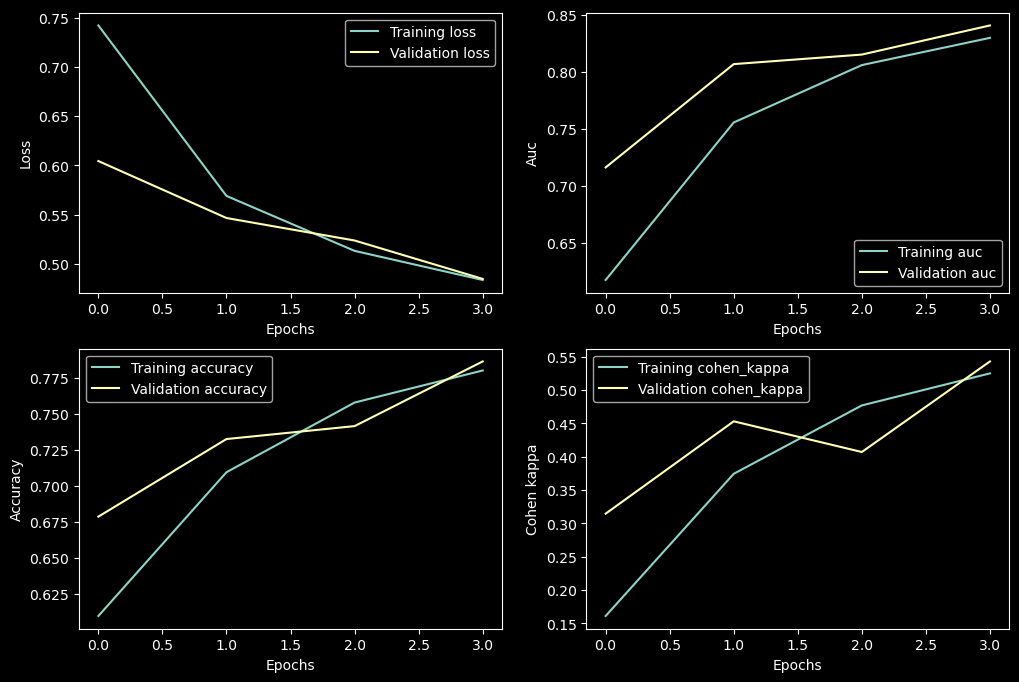

In [32]:
plot_all_metrics(history)

In [33]:
# get metrics values for the model in validation mode
evaluation_metrics = model.evaluate(validationset, verbose=1)

231/231 [==============================] - 130s 563ms/step - loss: 0.6008 - auc: 0.7226 - accuracy: 0.6835 - cohen_kappa: 0.3250 - f1_score: 0.5750


In [34]:
loss = evaluation_metrics.pop(0)

print(f"val loss    : {loss}")
for metric, score in zip(METRICS, evaluation_metrics):

    print(f"{metric.name + ' ' * (12 - len(metric.name))}: {score}")

val loss    : 0.6008323431015015
accuracy    : 0.7226077914237976
auc         : 0.683466911315918
cohen_kappa : 0.32496166229248047
f1_score    : 0.5749726295471191


In [35]:
clean_up(model)
clean_up(vgg)

### We do not train the weights of VGG

In [36]:
model = make_vgg_model(base_model=vgg)

In [37]:
# not train the weights
vgg.trainable = False

model.compile(
    optimizer=tf.keras.optimizers.Adam(
        1e-5
    ), 
    loss=tf.keras.losses.BinaryCrossentropy(),
    metrics=[metrics()],
)

In [38]:
history = model.fit(
    trainset,
    epochs=10,
    validation_data=validationset,
    callbacks=[early_stopping]
) 

Epoch 1/10
921/921 [==============================] - 616s 667ms/step - loss: 0.8232 - auc: 0.5916 - accuracy: 0.6077 - cohen_kappa: 0.1171 - f1_score: 0.3586 - val_loss: 0.6687 - val_auc: 0.6579 - val_accuracy: 0.6251 - val_cohen_kappa: 0.2226 - val_f1_score: 0.5380
Epoch 2/10
921/921 [==============================] - 642s 698ms/step - loss: 0.6977 - auc: 0.6381 - accuracy: 0.6219 - cohen_kappa: 0.1940 - f1_score: 0.4907 - val_loss: 0.6539 - val_auc: 0.6758 - val_accuracy: 0.6408 - val_cohen_kappa: 0.2564 - val_f1_score: 0.5593
Epoch 3/10
921/921 [==============================] - 613s 666ms/step - loss: 0.6766 - auc: 0.6519 - accuracy: 0.6308 - cohen_kappa: 0.2115 - f1_score: 0.4997 - val_loss: 0.6463 - val_auc: 0.6863 - val_accuracy: 0.6452 - val_cohen_kappa: 0.2741 - val_f1_score: 0.5797
Epoch 4/10
921/921 [==============================] - 623s 676ms/step - loss: 0.6633 - auc: 0.6613 - accuracy: 0.6376 - cohen_kappa: 0.2251 - f1_score: 0.5068 - val_loss: 0.6353 - val_auc: 0.6938 

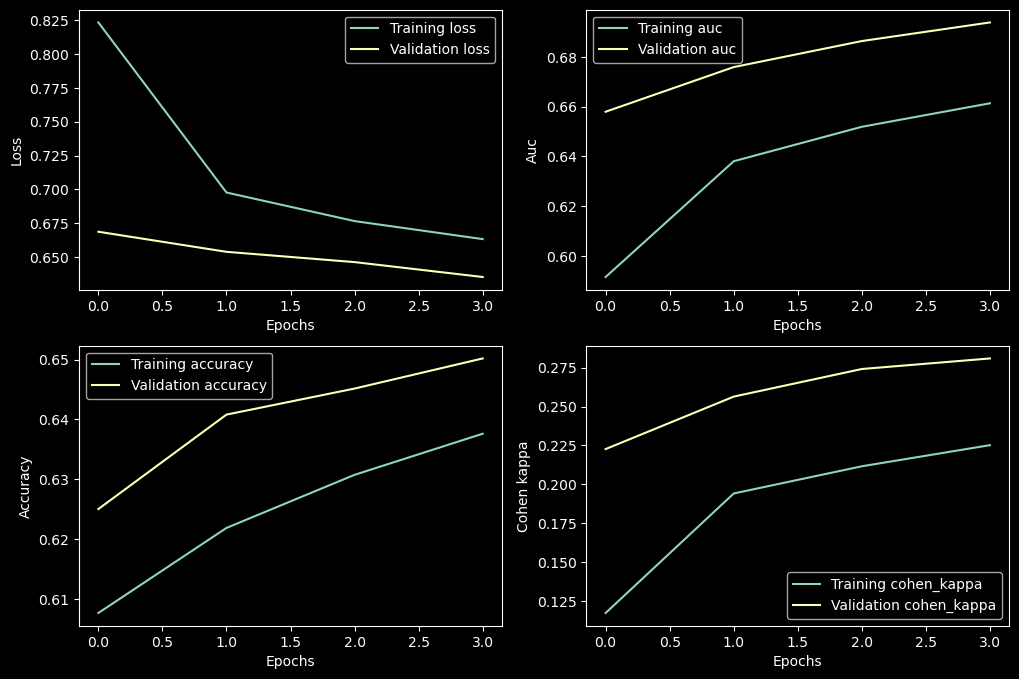

In [39]:
plot_all_metrics(history)

In [40]:
# get metrics values for the model in validation mode
evaluation_metrics = model.evaluate(validationset, verbose=1)

231/231 [==============================] - 129s 559ms/step - loss: 0.6669 - auc: 0.6613 - accuracy: 0.6342 - cohen_kappa: 0.2410 - f1_score: 0.5484


In [41]:
loss = evaluation_metrics.pop(0)

print(f"val loss    : {loss}")
for metric, score in zip(METRICS, evaluation_metrics):

    print(f"{metric.name + ' ' * (12 - len(metric.name))}: {score}")

val loss    : 0.6669164896011353
accuracy    : 0.661273717880249
auc         : 0.6341529488563538
cohen_kappa : 0.24101722240447998
f1_score    : 0.5483816862106323


In [42]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 vgg19 (Functional)          (None, 512)               20024384  
                                                                 
 dropout (Dropout)           (None, 512)               0         
                                                                 
 dense (Dense)               (None, 32)                16416     
                                                                 
 dense_1 (Dense)             (None, 1)                 33        
                                                                 
Total params: 20,040,833
Trainable params: 16,449
Non-trainable params: 20,024,384
_________________________________________________________________
